In [1]:
#  libraries install (sirf agar missing hon to)
# Run once. Colab mein yeh safe hai.
!pip install -q imbalanced-learn joblib


In [2]:
#  - imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                             precision_score, recall_score, f1_score, roc_auc_score, roc_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE
import joblib

sns.set_style('whitegrid')
%matplotlib inline


In [3]:
#  Download dataset directly from Kaggle using kagglehub
# (No manual upload needed, works online)

!pip install -q kagglehub

import kagglehub
import os

# Download the latest version of the dataset
path = kagglehub.dataset_download("pavansubhasht/ibm-hr-analytics-attrition-dataset")

print("✅ Dataset downloaded to:", path)
print("Files available:", os.listdir(path))

# Set the dataset path for later cells
DATA_FILE = os.path.join(path, "WA_Fn-UseC_-HR-Employee-Attrition.csv")
print("Using dataset file:", DATA_FILE)


100%|██████████| 50.1k/50.1k [00:00<00:00, 35.5MB/s]

Extracting files...
✅ Dataset downloaded to: /root/.cache/kagglehub/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset/versions/1
Files available: ['WA_Fn-UseC_-HR-Employee-Attrition.csv']
Using dataset file: /root/.cache/kagglehub/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset/versions/1/WA_Fn-UseC_-HR-Employee-Attrition.csv


In [5]:
# load CSV using kagglehub path

# 'path' variable already defined in Cell 3 (from kagglehub)
import os
import pandas as pd

# build full file path safely
DATA_FILE = os.path.join(path, "WA_Fn-UseC_-HR-Employee-Attrition.csv")

if not os.path.exists(DATA_FILE):
    # If filename is different, list files to check
    print("❌ File not found, available files are:", os.listdir(path))
    raise FileNotFoundError(f"Dataset not found at {DATA_FILE}")

# Load dataset
df = pd.read_csv(DATA_FILE)

print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
df.head()



✅ Dataset loaded successfully!
Shape: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [6]:
# Dataset Information and Missing Values Check
# yahan hum check karte hain ke dataset mein koi column missing ya null value to nahi hai,
# aur columns ka data type kya hai (numerical ya categorical).

df.info()   # Dataset ka basic info jaise column names, data types, non-null count
print("\nMissing values per column:")
print(df.isna().sum())  # Har column mein kitni missing values hain, yeh check karta hai


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                


Attrition value counts:
 Attrition
No     1233
Yes     237
Name: count, dtype: int64


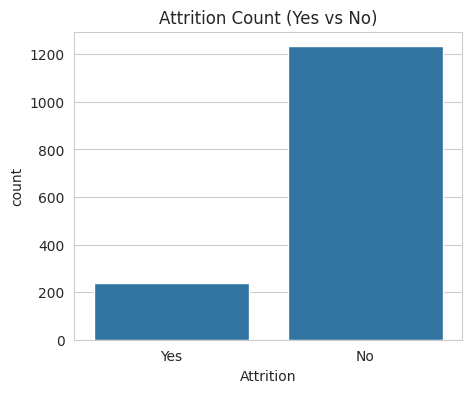

In [7]:
#  Target Column Distribution
# Target column 'Attrition' batata hai employee company chhoda (Yes) ya nahi (No)
# Hum check karte hain balance hai ya imbalance.

import seaborn as sns
import matplotlib.pyplot as plt

TARGET = 'Attrition'
print("\nAttrition value counts:\n", df[TARGET].value_counts())

plt.figure(figsize=(5,4))
sns.countplot(x=TARGET, data=df)
plt.title("Attrition Count (Yes vs No)")
plt.show()


Numerical Columns:
 ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

Categorical Columns:
 ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']


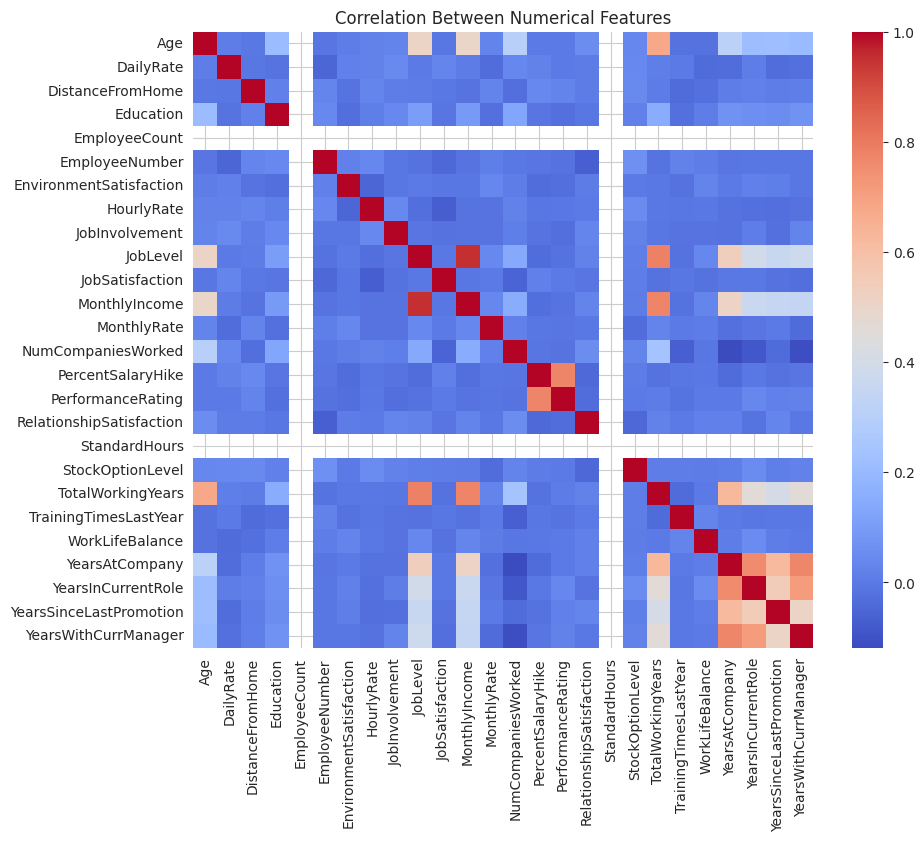

/tmp/ipython-input-945039514.py:21: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df[TARGET]=='Yes']['Age'], label='Left Company', shade=True)
/tmp/ipython-input-945039514.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df[TARGET]=='No']['Age'], label='Stayed', shade=True)


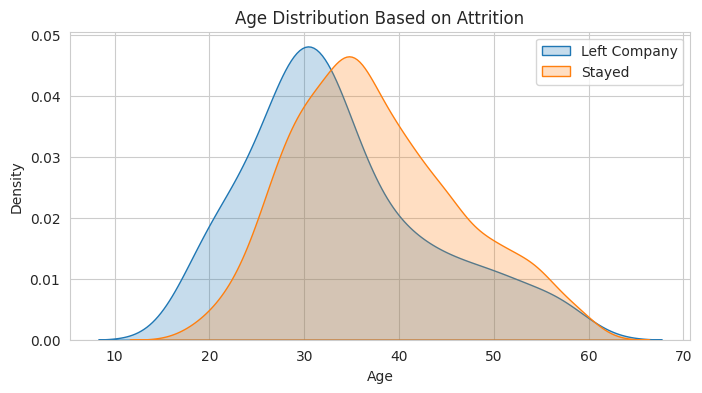

In [8]:
#  Exploratory Data Analysis (EDA)
# EDA ka matlab hota hai data samajhna - kaunse columns numeric hain, kaunse categorical
# aur unke relationships dekhna (correlation)

import numpy as np

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numerical Columns:\n", num_cols)
print("\nCategorical Columns:\n", cat_cols)

# Correlation heatmap numerical columns ke beech relation dikhata hai
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), cmap='coolwarm')
plt.title("Correlation Between Numerical Features")
plt.show()

# Example: Age ka Attrition ke saath relation
plt.figure(figsize=(8,4))
sns.kdeplot(df[df[TARGET]=='Yes']['Age'], label='Left Company', shade=True)
sns.kdeplot(df[df[TARGET]=='No']['Age'], label='Stayed', shade=True)
plt.title("Age Distribution Based on Attrition")
plt.legend()
plt.show()


In [9]:
#  Data Preprocessing
# Step 1: 'EmployeeNumber' ek unique ID hai, prediction mein use nahi hoti -> drop kar dete hain.
# Step 2: Target column 'Attrition' ko binary (Yes=1, No=0) mein convert karte hain.
# Step 3: Baaki categorical columns ko numerical banana hoga (one-hot encoding)

if 'EmployeeNumber' in df.columns:
    df = df.drop('EmployeeNumber', axis=1)

df[TARGET] = df[TARGET].map({'Yes':1, 'No':0})

obj_cols = [c for c in df.columns if df[c].dtype == 'object']
print("Categorical Columns to Encode:", obj_cols)

# One-hot encoding karta hai categorical ko numeric mein (0/1)
df_encoded = pd.get_dummies(df, columns=obj_cols, drop_first=True)
print("After Encoding Shape:", df_encoded.shape)


Categorical Columns to Encode: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']
After Encoding Shape: (1470, 47)


In [10]:
#  Split Data into Training and Testing
# Ab data ko training (80%) aur testing (20%) mein divide karte hain.
# Training se model seekhega, testing se model check hoga.

from sklearn.model_selection import train_test_split

X = df_encoded.drop(TARGET, axis=1)
y = df_encoded[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (1176, 46)
Test shape: (294, 46)


In [11]:
#  Handle Imbalance using SMOTE
# 'Yes' (attrition) cases kam hote hain, to SMOTE use karte hain taake data balanced ho jaye.
# SMOTE (Synthetic Minority Oversampling Technique) new synthetic examples banata hai minority class ke liye.

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_res))


Before SMOTE: [986 190]
After SMOTE: [986 986]


In [12]:
# Feature Scaling
# Logistic Regression jaise models data ke scale pe sensitive hote hain,
# isliye hum StandardScaler use karke features ko normalize karte hain.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

print("Feature Scaling Complete ✅")


Feature Scaling Complete ✅



--- Training LogisticRegression ---
Accuracy: 0.857 | ROC AUC: 0.721

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       247
           1       0.57      0.43      0.49        47

    accuracy                           0.86       294
   macro avg       0.73      0.68      0.70       294
weighted avg       0.84      0.86      0.85       294



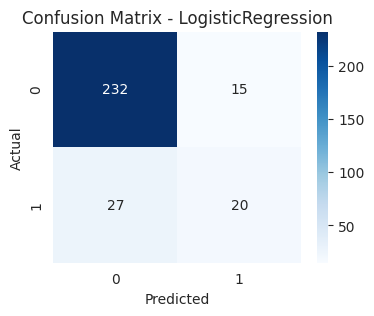


--- Training DecisionTree ---
Accuracy: 0.735 | ROC AUC: 0.575

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.81      0.84       247
           1       0.25      0.34      0.29        47

    accuracy                           0.73       294
   macro avg       0.56      0.58      0.56       294
weighted avg       0.77      0.73      0.75       294



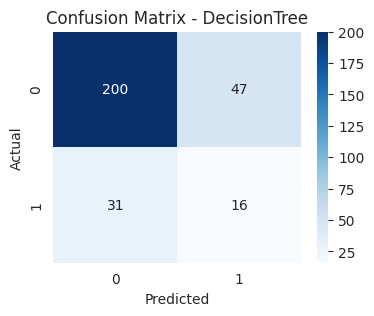


--- Training RandomForest ---
Accuracy: 0.830 | ROC AUC: 0.735

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90       247
           1       0.44      0.26      0.32        47

    accuracy                           0.83       294
   macro avg       0.66      0.60      0.61       294
weighted avg       0.80      0.83      0.81       294



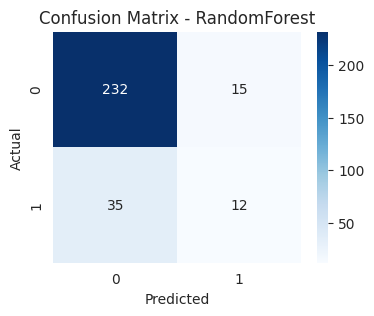

In [13]:
#  Model Training and Evaluation
# Hum 3 models train karenge:
# 1) Logistic Regression
# 2) Decision Tree
# 3) Random Forest

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n--- Training {name} ---")

    if name == 'LogisticRegression':
        model.fit(X_train_scaled, y_train_res)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:,1]
    else:
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    print(f"Accuracy: {acc:.3f} | ROC AUC: {roc:.3f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(4,3))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.show()

    results[name] = {'accuracy':acc, 'roc_auc':roc}


/tmp/ipython-input-818848268.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


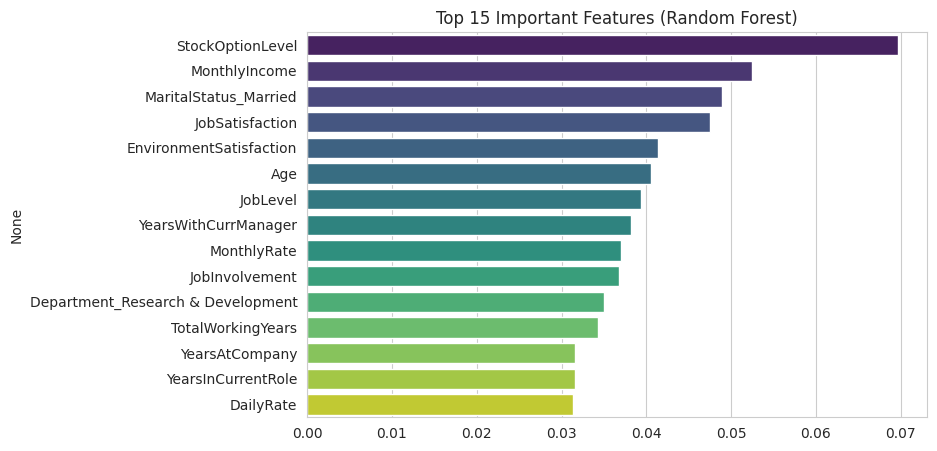

In [14]:
#  Feature Importance Visualization
# Random Forest se pata chalega kaunse features attrition predict karne mein important hain.

rf = models['RandomForest']
importances = rf.feature_importances_
feat_names = X.columns

top_features = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(15)

plt.figure(figsize=(8,5))
sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")
plt.title("Top 15 Important Features (Random Forest)")
plt.show()


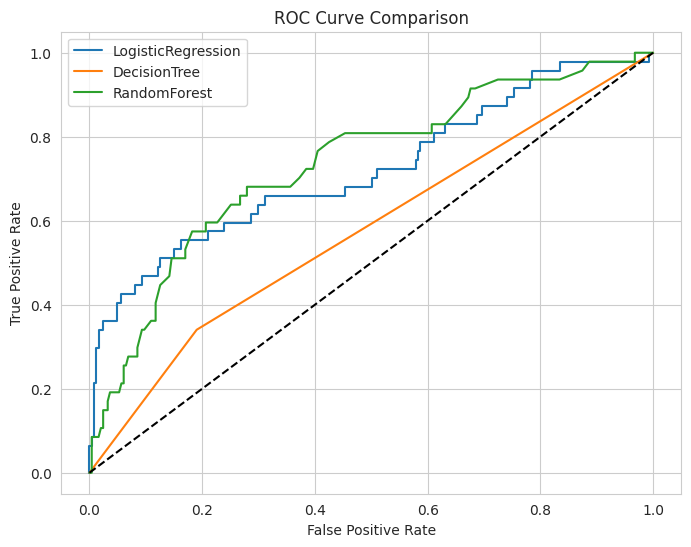

In [15]:
# ROC Curves of All Models
# ROC curve dikhata hai models ki performance (True Positive vs False Positive)

from sklearn.metrics import roc_curve

plt.figure(figsize=(8,6))
for name, model in models.items():
    try:
        if name == 'LogisticRegression':
            y_proba = model.predict_proba(X_test_scaled)[:,1]
        else:
            y_proba = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name}")
    except:
        pass

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()


In [16]:
#  Save Best Model and Scaler
# Best model choose karte hain F1 ya ROC AUC ke basis pe, aur usko save karte hain.

import joblib
best_model_name = max(results, key=lambda x: results[x]['roc_auc'])
print("Best Model:", best_model_name)

best_model = models[best_model_name]
joblib.dump(best_model, f"{best_model_name}_model.joblib")
joblib.dump(scaler, "scaler.joblib")

print("Model and Scaler saved successfully ✅")


Best Model: RandomForest
Model and Scaler saved successfully ✅


In [17]:
# - Requirements and Git Commit Message
# Ye cell automatically requirements.txt aur suggested commit message banata hai.

requirements = """
pandas
numpy
matplotlib
seaborn
scikit-learn
imbalanced-learn
joblib
"""

with open('requirements.txt', 'w') as f:
    f.write(requirements)

print("✅ requirements.txt file created.")

commit_msg = (
    "Added Employee Attrition Analyzer project using Kaggle dataset (IBM HR Analytics). "
    "Includes data preprocessing, EDA, SMOTE, and models (Logistic Regression, Decision Tree, Random Forest)."
)
print("\nSuggested Commit Message:\n", commit_msg)


✅ requirements.txt file created.

Suggested Commit Message:
 Added Employee Attrition Analyzer project using Kaggle dataset (IBM HR Analytics). Includes data preprocessing, EDA, SMOTE, and models (Logistic Regression, Decision Tree, Random Forest).
